### Deep Learning with Python - winter semester 2022/2023
### Final Project

## The Simpsons Character Classification with GloVe and BERT - a comparison of language models and architectures

### Group members: Maria-Teresa de Rosa Palmini, Andrea Schröter

The goal of the following code is to build neural networks using GloVe and BERT embeddings to solve a multiclass classification problem, namely to assign a character of "The Simpsons" to their utterances in the script. For this task, a dataset containing extracts of the script of roughly 600 episodes uttered by more than 6000 characters was used (https://www.kaggle.com/datasets/prashant111/the-simpsons-dataset). Our prediction is that the model using BERT embeddings will outperform the model using GloVe embeddings since contextual embeddings are said to yield state of the art performance in a wide range of NLP applications (cf. Frassinelli 2022, Devlin et al. 2018).

The first step involves preprocessing of the dataset (getting rid of unnecessary columns, the least frequent characters, balancing of classes, padding, tokenizing and one-hot encoding of the label data). In the second step, a model using GloVe embeddings was compared for the dataset containing the 20 and 4 most frequent labels. Then, for the dataset containing 4 labels, a more complex version of the model was tested. For this, we increased the size of the units of the LSTM layer to 64 and added another LSTM layer with 64 units. Lastly, for the dataset containing 4 labels we tested a model using BERT embeddings and compared the performance with that of the models using GloVe embeddings.

## Part 1:
### Analysis, Manipulation and Splitting of Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# create dataframe from the csv file 
df = pd.read_csv('/compLing/students/courses/deepLearning/finalProject23/andrea.schroeter/simpsons_script_lines.csv')
#df = pd.read_csv('/kaggle/input/the-simpsons-dataset/simpsons_script_lines.csv')

# have a look at the last line
df[:1]

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31


In [3]:
num_rows = df.shape[0]
print(f"The dataset contains {num_rows} rows.")


The dataset contains 158271 rows.


In [4]:
# dropping unecessary columns in the dataset (we are only interested in the character name, text and word count)
df = df.drop(["spoken_words", "id", "episode_id", "number", "timestamp_in_ms" ,"speaking_line", "character_id", "location_id", "raw_text", "raw_location_text"], axis=1)
df.head()

,raw_character_text,normalized_text,word_count
0,Miss Hoover,no actually it was a little of both sometimes ...,31
1,Lisa Simpson,wheres mr bergstrom,3
2,Miss Hoover,i dont know although id sure like to talk to h...,22
3,Lisa Simpson,that life is worth living,5
4,Edna Krabappel-Flanders,the polls will be open from now until the end ...,33


In [5]:
# renaming column names for simplicity 
df.rename(columns = {'raw_character_text':'character_name', 'normalized_text':'text'}, inplace = True)
df.head()

,character_name,text,word_count
0,Miss Hoover,no actually it was a little of both sometimes ...,31
1,Lisa Simpson,wheres mr bergstrom,3
2,Miss Hoover,i dont know although id sure like to talk to h...,22
3,Lisa Simpson,that life is worth living,5
4,Edna Krabappel-Flanders,the polls will be open from now until the end ...,33


In [6]:
# check for null values
null_counts = df.isnull().sum()

# print null counts for the columns
print(null_counts)

character_name    17522
text              26184
word_count        26159
dtype: int64


In [7]:
# drop rows with null values for character_name and text
df= df.dropna(subset=['character_name', 'text'])

In [8]:
# check for null values to ensure they were dropped
null_counts = df.isnull().sum()

print(null_counts)

character_name    0
text              0
word_count        0
dtype: int64


In [9]:
# drop similar lines (duplicates)
print(len(df))
print(len(df.text.unique()))
df = df.drop_duplicates(subset=['text'])
print(len(df.text))

132085
119803
119803


['31' '3' '22' '5' '33' '8' '1' '4' '19' '10' '9' '6' '2' '15' '7' '11'
 '13' '12' '43' '23' '20' '30' '29' '16' '18' '40' '67' '21' '17' '41'
 '27' '50' '28' '14' '26' '32' '25' '87' '36' '24' '34' '38' '49' '51'
 '44' '37' '46' '64' '42' '35' '55' '70' '68' '39' '61' '58' '59' '45'
 '54' '53' '52' '48' '62' '90' '56' '47' '103' '71' 'true' '60' '63' '122'
 '85' '57' '73' '106' '78' '69' '75' '81' '76' '91' '72' '74' '80' '111'
 '66' '571000' '82' '88' '1145000' '100' '672000' '147000' '409000'
 'I\'m a Selma."' '84' '117000' '65'
 'and presto -- you\'re part of the under-clown railroad! So you got any talent?"'
 '116' '79' '105' '98' '77'
 'just don\'t ask me to drive you to the airport."' '110' '114'
 'the fact that it wasn\'t me. I\'ve never felt so alive."' '1154000' '83'
 '108000']
7334
0


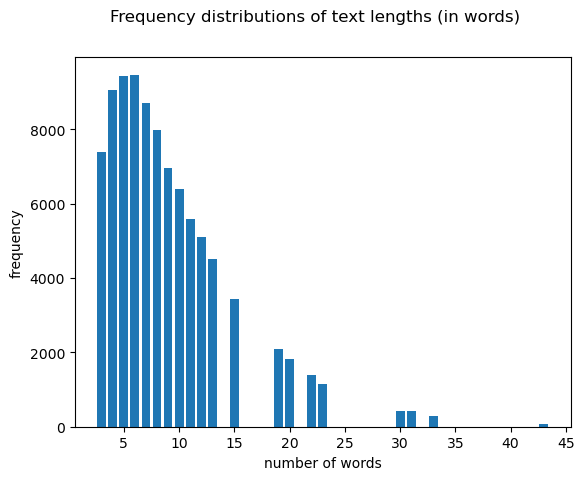

In [10]:
# looking at unique values of word counts 
print(df['word_count'].unique())

'''The word counts also contain non integer values which we want to remove.
Moreover, we think that word counts <= 2 are not very informative, since they can contain utterances like "yes" or "no"
which we doubt are highly character specific.
'''

# casting word counts to integers, if not possible remove row
for index, row in df.iterrows():
    try:
        row['word_count'] = int(row['word_count'])
    except:
        df.drop(index, inplace=True)
    
df['word_count'] = df['word_count'].astype('int')

# print number of rows with a word count <= 2
print(len(df[df['word_count'] <= 2]))

# drop rows with word count <= 2
df.drop(df[df.word_count <= 2].index, inplace=True)

# make sure we deleted rows with a word count <= 2
print(len(df[df['word_count'] <= 2]))

# plot the 20 most frequent word counts (important for deciding truncation and maximum length of text)

counts = df['word_count'].unique()[:20] 
frequencies = [len(df.loc[df.values == count]) for count in counts] 

fig = plt.figure()
plt.bar(counts, frequencies)
fig.suptitle('Frequency distributions of text lengths (in words)')
plt.xlabel('number of words')
plt.ylabel('frequency')
plt.show()

In [11]:
# 20 most frequent characters 
frequent_characters = df['character_name'].value_counts().head(20)

<AxesSubplot:>

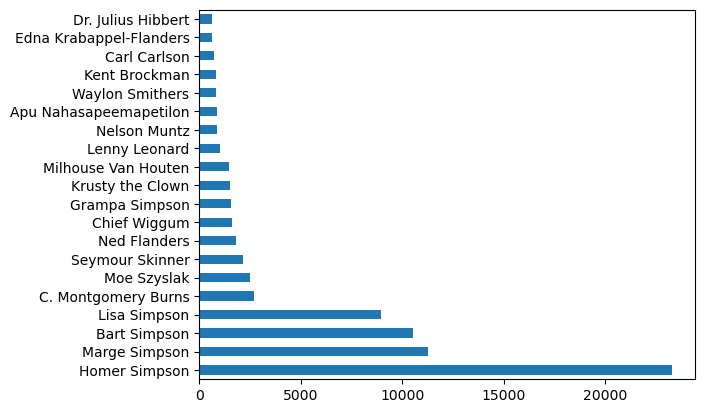

In [12]:
# create bar chart of the top 20 most frequent characters
frequent_characters.plot(kind='barh')

In [13]:
# calculate percentage of samples in each class (character name)
class_percentages = frequent_characters / len(df) * 100

# print the class percentages
print(class_percentages)

Homer Simpson              20.695389
Marge Simpson              10.017340
Bart Simpson                9.376195
Lisa Simpson                7.948957
C. Montgomery Burns         2.396514
Moe Szyslak                 2.240896
Seymour Skinner             1.900316
Ned Flanders                1.611311
Chief Wiggum                1.453915
Grampa Simpson              1.395225
Krusty the Clown            1.360544
Milhouse Van Houten         1.288515
Lenny Leonard               0.890134
Nelson Muntz                0.794985
Apu Nahasapeemapetilon      0.767418
Waylon Smithers             0.752301
Kent Brockman               0.751412
Carl Carlson                0.653595
Edna Krabappel-Flanders     0.562003
Dr. Julius Hibbert          0.553999
Name: character_name, dtype: float64


Given the frequency of the 20 most frequent class labels (character names) we see that the dataset is very imbalanced. „Homer Simpson“ is the most frequent character with a percentage of 20.82%, followed by „Marge Simpson“ (10.05 %), „Bart Simpson“ (9.42 %) and „Lisa Simpson“ with 7.97 %. All other characters are very infrequent (less than 2.4 %, e.g. „Dr. Julius Hibbert“ with a percentage of 0.55 %). This is problematic as it can affect the performance of the classifier because the model could become biased towards the majority classes. It could not generalize well regarding the less frequent classes (cf. Liu & Zhou 2008). To avoid this problem and to balance the classes, we created a second dataset containing the four most frequent labels.

In [14]:
# Select the top 4 (Lisa, Bart, Marge and Homer Simpson) and 20 most frequent labels
top_20_labels = frequent_characters.head(20).index
top_4_labels = frequent_characters.head(4).index

# Create a new DataFrame containing only the rows that have one of the top 20 most frequent labels
new_df = df[df['character_name'].isin(top_20_labels)]

# Create a new DataFrame containing only the rows that have one of the top 4 most frequent labels
new_df_4 = df[df['character_name'].isin(top_4_labels)]
new_df_4.head()

,character_name,text,word_count
1,Lisa Simpson,wheres mr bergstrom,3
3,Lisa Simpson,that life is worth living,5
7,Bart Simpson,victory party under the slide,5
9,Lisa Simpson,mr bergstrom mr bergstrom,4
11,Lisa Simpson,do you know where i could find him,8


To adress the imbalance problem we applied undersampling. Undersampling is a sampling technique where only a subset of the majority class is used (cf. Liu & Zhou 2008). This subset matches the number of examples of the minority class.

In [15]:
# undersampling based on the steps in this tutorial: https://blog.madhukaraphatak.com/class-imbalance-part-2

# determine minority class
minority_class = new_df_4['character_name'].value_counts().idxmin()

# split dataset into minority and majority classes
minority_subset = new_df_4[new_df_4['character_name'] == minority_class]
majority_subset = new_df_4[new_df_4['character_name'] != minority_class]

# number of examples of majority classes should match the number of samples in the minority class
majority_subset = majority_subset.groupby('character_name').apply(lambda x: x.sample(n=len(minority_subset)))

# combine the minority and the majority subset
dataframe4 = pd.concat([minority_subset, majority_subset])

# shuffle rows
dataframe4 = dataframe4.sample(frac=1, random_state=42)

In [16]:
unique_labels = dataframe4['character_name'].value_counts()

# determine the percentage of samples in each class
class_percentages = unique_labels / len(df) * 100

print(class_percentages)

Homer Simpson    7.948957
Lisa Simpson     7.948957
Marge Simpson    7.948957
Bart Simpson     7.948957
Name: character_name, dtype: float64


In [17]:
print(f"The new dataframe now contains {dataframe4.shape[0]} examples.")

The new dataframe now contains 35756 examples.


In [18]:
char_df = pd.DataFrame(new_df, columns=['character_name','text'])
char_df_4 = pd.DataFrame(dataframe4, columns=['character_name','text'])

# converting type of columns to 'category'
char_df['character_name'] = char_df['character_name'].astype('category')
char_df_4['character_name'] = char_df_4['character_name'].astype('category')

# assigning character names a numerical values and storing in the column 'character_name_cat'
char_df['character_name_cat'] = char_df['character_name'].cat.codes
char_df
char_df_4['character_name_cat'] = char_df_4['character_name'].cat.codes
char_df_4

,character_name,text,character_name_cat
"(Homer Simpson, 57241)",Homer Simpson,maybe you should shut up,1
27873,Lisa Simpson,wow mom you didnt have to go to this much trouble,2
"(Marge Simpson, 7544)",Marge Simpson,hmmm i hope my poor little babys okay,3
"(Marge Simpson, 5414)",Marge Simpson,there you go lisa no pimentos bart your hats w...,3
"(Marge Simpson, 85109)",Marge Simpson,principal skinner is having second thoughts po...,3
...,...,...,...
"(Bart Simpson, 132552)",Bart Simpson,yknow its really not fair youre charging two h...,0
110350,Lisa Simpson,why cant you just admit were lost,2
"(Bart Simpson, 57587)",Bart Simpson,stomp that pickle revert,0
19294,Lisa Simpson,its perfect dad,2


In [19]:
# dropping columns in the dataset that are no longer needed
df = char_df.drop(["character_name"], axis=1)

df_4 = char_df_4.drop(["character_name"], axis=1)
df_4.head()

,text,character_name_cat
"(Homer Simpson, 57241)",maybe you should shut up,1
27873,wow mom you didnt have to go to this much trouble,2
"(Marge Simpson, 7544)",hmmm i hope my poor little babys okay,3
"(Marge Simpson, 5414)",there you go lisa no pimentos bart your hats w...,3
"(Marge Simpson, 85109)",principal skinner is having second thoughts po...,3


In [20]:
# extract the content of the column 'text' from the dataframe

dialogues = df['text'].values # 20 labels
dialogues_4 = df_4['text'].values # 4 labels

# tokenizing and padding of text data and one-hot encoding of label data

import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_word_num = 1000 # only consider the 1000 most frequent words
max_len_seq = 40 # cut off text after 40 tokens (due to frequency distribution of text lengths above)

# tokenize dataset containing 20 labels
tokenizer = Tokenizer(num_words = max_word_num)
tokenizer.fit_on_texts(dialogues)
sequences = tokenizer.texts_to_sequences(dialogues)

word_index = tokenizer.word_index
print('Found %s unique tokens in the dataset containing the 20 most frequent labels.' % len(word_index))

# tokenize dataset containing 4 labels
tokenizer = Tokenizer(num_words = max_word_num)
tokenizer.fit_on_texts(dialogues_4)
sequences_4 = tokenizer.texts_to_sequences(dialogues_4)
word_index_4 = tokenizer.word_index
print('Found %s unique tokens for the dataset containing the 4 most frequent character labels.' % len(word_index_4))

# padding
text = pad_sequences(sequences, maxlen = max_len_seq)
text_4 = pad_sequences(sequences_4, maxlen = max_len_seq)

# use one-hot encoding to convert labels
labels = to_categorical(np.asarray(df['character_name_cat']))
labels_4 = to_categorical(np.asarray(df_4['character_name_cat'])) 

print('The shape of the dialogue tensor for the dataset with 20 labels is:', text.shape)
print('The shape of the labels tensor for the dataset with 20 labels is:', labels.shape)

print('The shape of the dialogue tensor for the datast with 4 labels is:', text_4.shape)
print('The shape of the labels tensor for the dataset with 4 labels is:', labels_4.shape)

Found 30887 unique tokens in the dataset containing the 20 most frequent labels.
Found 19693 unique tokens for the dataset containing the 4 most frequent character labels.
The shape of the dialogue tensor for the dataset with 20 labels is: (75807, 40)
The shape of the labels tensor for the dataset with 20 labels is: (75807, 20)
The shape of the dialogue tensor for the datast with 4 labels is: (35756, 40)
The shape of the labels tensor for the dataset with 4 labels is: (35756, 4)


In [21]:
# shuffling data (cf. Chollet 2019: 190)

# for 20 labels

indices = np.arange(text.shape[0])
np.random.shuffle(indices)
text = text[indices]
labels = labels[indices]

# for 4 labels

indices_4 = np.arange(text_4.shape[0])
np.random.shuffle(indices_4)
text_4 = text_4[indices_4]
labels_4 = labels_4[indices_4]

# splitting data into train, validation and test data (80-10-10)

# for the dataset containing 20 labels
training_samples = int(len(df)*0.8)
validation_samples = int(len(df)*0.1)
test_samples = int(len(df)*0.1)


x_train = text[:training_samples] 
y_train = labels[:training_samples]
x_val = text[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
x_test = text[validation_samples: validation_samples + test_samples]
y_test = labels[validation_samples: validation_samples + test_samples]

print("Training data shape for 20 labels:", x_train.shape)
print("Validation data shape for 20 labels:", x_val.shape)
print("Test data shape for 20 labels:", x_test.shape)

# for the dataset containing 4 labels

training_samples = int(len(df_4)*0.8)
validation_samples = int(len(df_4)*0.1)
test_samples = int(len(df_4)*0.1)

x_train_4 = text_4[:training_samples] 
y_train_4 = labels_4[:training_samples]
x_val_4 = text_4[training_samples: training_samples + validation_samples]
y_val_4 = labels_4[training_samples: training_samples + validation_samples]
x_test_4 = text_4[validation_samples: validation_samples + test_samples]
y_test_4 = labels_4[validation_samples: validation_samples + test_samples]

print("Training data shape for 4 labels:", x_train_4.shape)
print("Validation data shape for 4 labels:", x_val_4.shape)
print("Test data shape for 4 labels:", x_test_4.shape)

Training data shape for 20 labels: (60645, 40)
Validation data shape for 20 labels: (7580, 40)
Test data shape for 20 labels: (7580, 40)
Training data shape for 4 labels: (28604, 40)
Validation data shape for 4 labels: (3575, 40)
Test data shape for 4 labels: (3575, 40)


# Part 2:
### Train a model using GloVe embeddings

### 2.1 Preprocess GloVe embeddings (cf. Chollet 2018: 190)

For the embeddings, we used the "GloVe Common Crawl" embeddings, which were trained on web data. We thought it may be more suitable to the transcripts than embeddings trained on wikipedia or tweets. 

In [96]:
embeddings_dict = {}

# to show the percentage progress for the progress bar
num_of_lines = sum(1 for line in open('/compLing/students/courses/deepLearning/finalProject23/andrea.schroeter/glove.42B.300d.txt')) # https://stackoverflow.com/questions/845058/how-to-get-line-count-of-a-large-file-cheaply-in-python

with open('/compLing/students/courses/deepLearning/finalProject23/andrea.schroeter/glove.42B.300d.txt',"r", encoding='utf-8') as f:
    for line in tqdm(f, total=num_of_lines):
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = vector

embedding_dim = 300

# build an embedding matrix to load into Embedding layer of shape (max_words, embedding_dim) for the dataset containing 20 labels
embedding_matrix = np.zeros((max_word_num, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if i < max_word_num:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
# ... and for the dataset containing 4 labels

embedding_matrix_4 = np.zeros((max_word_num, embedding_dim))
for word, i in word_index_4.items():
    embedding_vector = embeddings_dict.get(word)
    if i < max_word_num:
        if embedding_vector is not None:
            embedding_matrix_4[i] = embedding_vector

100%|██████████| 1917494/1917494 [02:45<00:00, 11608.92it/s]


### 2.2 Comparing the model's performance trained on the datasets containing 4 and 20 labels

In [97]:
# model trained on dataset containing 20 labels 

from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, LSTM

model = Sequential() 
# embedding layer for the pretrained GloVe embeddings
model.add(Embedding(max_word_num, embedding_dim, input_length=max_len_seq)) 
model.add(LSTM(8)) # use LSTM layer to capture long-term dependencies in text and to prevent the vanishing gradient problem (cf. Chollet 2018: 202)
model.add(Dense(20, activation='softmax')) 
'''We chose a Dense layer with 20 output units because we have 20 different labels. Because it is a multiclass classification task,
we used softmax as the activation function and categorical_crossentropy as the loss function. '''

# load GloVe embeddings in membedding layer and prevent parameters from being trainable
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.summary()


Model: "sequential_7"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


embedding_7 (Embedding)      (None, 40, 300)           300000    

_________________________________________________________________

lstm_12 (LSTM)               (None, 8)                 9888      

_________________________________________________________________

dense_7 (Dense)              (None, 20)                180       


Total params: 310,068

Trainable params: 10,068

Non-trainable params: 300,000

_________________________________________________________________


In [98]:
'''compile the model with optimizer, loss function and accuracy as a metric
Note: would have been maybe better to use precision/recall as a metric because we are dealing with a very imbalanced dataset. 
However, we wanted to compare the model trained on 20 labels with the ones trained on the 4 most frequent labels.
We chose the RMSprop optimizer because it is often used for recurrent neural networks (Pascanu et al.,2013).
'''

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

# fit model on training data and training labels, train over 10 epochs with batch size 64
history = model.fit(x_train, y_train,
epochs=10,
batch_size=64,
validation_data=(x_val, y_val)) # validation split was 0.1 (see above)

Epoch 1/10

948/948 [==============================] - 19s 18ms/step - loss: 2.3172 - acc: 0.3101 - val_loss: 2.2328 - val_acc: 0.3182

Epoch 2/10

948/948 [==============================] - 16s 17ms/step - loss: 2.1845 - acc: 0.3365 - val_loss: 2.1482 - val_acc: 0.3470

Epoch 3/10

948/948 [==============================] - 17s 17ms/step - loss: 2.1197 - acc: 0.3549 - val_loss: 2.0993 - val_acc: 0.3583

Epoch 4/10

948/948 [==============================] - 17s 18ms/step - loss: 2.0787 - acc: 0.3644 - val_loss: 2.0750 - val_acc: 0.3596

Epoch 5/10

948/948 [==============================] - 17s 18ms/step - loss: 2.0538 - acc: 0.3693 - val_loss: 2.0642 - val_acc: 0.3640

Epoch 6/10

948/948 [==============================] - 17s 18ms/step - loss: 2.0368 - acc: 0.3749 - val_loss: 2.0431 - val_acc: 0.3724

Epoch 7/10

948/948 [==============================] - 17s 18ms/step - loss: 2.0241 - acc: 0.3769 - val_loss: 2.0349 - val_acc: 0.3730

Epoch 8/10

948/948 [===========================

In [99]:
# 4 labels 

model_2 = Sequential() 

model_2.add(Embedding(max_word_num, embedding_dim, input_length=max_len_seq)) 
model_2.add(LSTM(8)) 
model_2.add(Dense(4, activation='softmax')) 


model_2.layers[0].set_weights([embedding_matrix_4])
model_2.layers[0].trainable = False

model_2.summary()


model_2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

history_2 = model_2.fit(x_train_4, y_train_4,
epochs=10,
batch_size=64,
validation_data=(x_val_4, y_val_4))

Model: "sequential_8"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


embedding_8 (Embedding)      (None, 40, 300)           300000    

_________________________________________________________________

lstm_13 (LSTM)               (None, 8)                 9888      

_________________________________________________________________

dense_8 (Dense)              (None, 4)                 36        


Total params: 309,924

Trainable params: 9,924

Non-trainable params: 300,000

_________________________________________________________________

Epoch 1/10

447/447 [==============================] - 10s 20ms/step - loss: 1.3591 - acc: 0.3189 - val_loss: 1.3168 - val_acc: 0.3748

Epoch 2/10

447/447 [==============================] - 8s 18ms/step - loss: 1.2678 - acc: 0.4070 - val_loss: 1.2420 - val_acc: 0.4076

Epoch 3/10

447/447 [==============================] - 8s 18ms/step - loss: 1.2162 - acc:

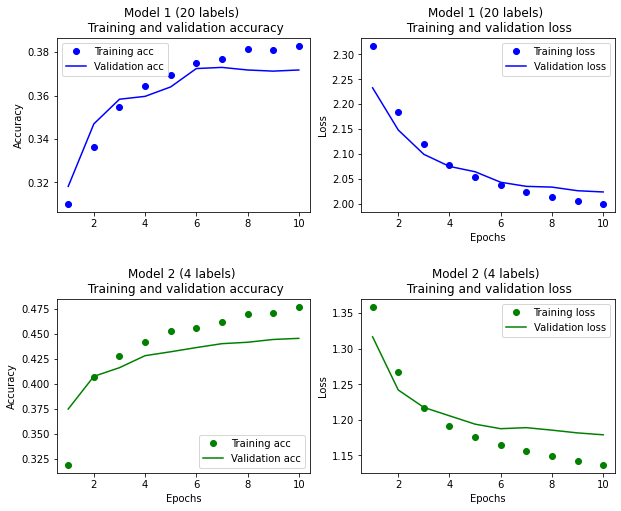

In [100]:
# Plotting the accuracy and loss of the training and validation data for the first (20 labels) and second model (4 labels) (cf. Chollet 2018: 192)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Model 1 (20 labels)
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.subplot(2, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Model 1 (20 labels) \n Training and validation accuracy')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model 1 (20 labels) \n Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Model 2 (4 labels)
acc_2 = history_2.history['acc']
val_acc_2 = history_2.history['val_acc']
loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']
epochs_2 = range(1, len(acc_2) + 1)

plt.subplot(2, 2, 3)
plt.plot(epochs_2, acc_2, 'go', label='Training acc')
plt.plot(epochs_2, val_acc_2, 'g', label='Validation acc')
plt.title('Model 2 (4 labels) \n Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs_2, loss_2, 'go', label='Training loss')
plt.plot(epochs_2, val_loss_2, 'g', label='Validation loss')
plt.title('Model 2 (4 labels) \n Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplots_adjust(hspace=0.5)

plt.show()

In [101]:
# evaluate on the test set
model.evaluate(x_test, y_test) # 20 labels
model_2.evaluate(x_test_4, y_test_4) # 4 labels

237/237 [==============================] - 1s 4ms/step - loss: 1.9883 - acc: 0.3821

112/112 [==============================] - 0s 3ms/step - loss: 1.1232 - acc: 0.4783


[1.1231552362442017, 0.4783216714859009]

### Discussion

After training the model on the dataset with 20 labels for 10 epochs we reach an accuracy of 0.38 and a loss of 1.99 for the training data. For the validation data, we achieve an accuracy of 0.37 and a loss of 2.02. The accuracy of the training data is slightly higher, which might indicate overfitting, i.e. the model performs better on the training than on the validation data (never seen data). This indicates that the model learned "representations that are specific to the training data and [doesn’t] generalize to data outside of the training set" (Chollet 2018: 76). In the plot we can also observe that the validation accuracy is stagnating after the 6th epoch. We achieve a test accuracy of 0.3821, which is slightly lower than the training accuracy (0.3829). 

For the model trained on the dataset containing 4 labels (a dataset undersampled to adress the imbalance of the dataset) we obtained a training loss of 1.14, a training accuracy of 0.48, a validation loss of 1.18 and a validation accuracy of 0.45. The validation accuracy only slightly increases after the 5th epoch. The training accuracy (0.4772) is higher than the validation accuracy, however, the test accuracy (0.4783) is slightly higher than the training accuracy, which might indicate a slight underfitting (i.e. "the network hasn’t yet modeled all relevant patterns in the training data" (Chollet 2018: 104)). On the other hand, the test accuracy is only slightly higher than the training accuracy and random shuffling by chance might have resulted in a test data set that is "simpler" for the model or that there was a form of data leakage. Another explanation would be that the model might be too simple to capture all relevant data. In order to test whether a too simplistic model could be responsible for the better performance on the test data, we increased hte complexity of the model's architecture by adding another LSTM layer with 64 units. To prevent overfitting, we used dropout regularization (see 2.3).

Generally, the accuracy achieved by the model trained on the undersampled dataset with 4 labels is higher than the accuracy of the model trained on the dataset with 20 labels. This could be explained by the fact that we applied undersampling to the dataset containing 4 labels. In addition, the task of learning to classify four different characters is simpler than learning how to map 20 characters to their corresponding utterances, resulting in a higher accuracy of the model trained on the dataset with 4 labels. However, we observe a slightly bigger overfitting between training and validation accuracy compared to the model trained on the dataset with 20 labels. This could be explained by the decreased sample size for the dataset containing 4 labels due to the undersampling procedure. 

### 2.3 Experimentation with model's architecture (focussing on the first model trained on data containing 20 character labels)

In order to test whether a too simplistic model could be responsible for the higher test accuracy (2.2), we increased the size of the units of the LSTM layer to 64 and added another LSTM layer with 64 units to increase the complexity of the model. We used dropout regularization with a rate of 0.2 after the first LSTM layer to prevent overfitting in reccurent layers (cf. Chollet 2018: 207). "The dropout rate is the fraction of the features that are zeroed out; it’s usually set between 0.2 and 0.5." (Chollet 2018: 109). We changed the optimizer to Adam because it is said to perform equal to or outperform RMSProp (cf. Kingma & Ba 2014).

In [102]:
from keras.layers import Dropout

model_3 = Sequential() 

model_3.add(Embedding(max_word_num, embedding_dim, input_length=max_len_seq)) 
model_3.add(LSTM(64, return_sequences=True)) 
model_3.add(Dropout(0.2))
model_3.add(LSTM(64)) 
model_3.add(Dense(4, activation='softmax')) 

model_3.layers[0].set_weights([embedding_matrix])
model_3.layers[0].trainable = False

model_3.summary()

model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics= ['acc'])

history3 = model_3.fit(x_train_4, y_train_4,
epochs=10,
batch_size=64,
validation_data=(x_val_4, y_val_4))

Model: "sequential_9"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


embedding_9 (Embedding)      (None, 40, 300)           300000    

_________________________________________________________________

lstm_14 (LSTM)               (None, 40, 64)            93440     

_________________________________________________________________

dropout_3 (Dropout)          (None, 40, 64)            0         

_________________________________________________________________

lstm_15 (LSTM)               (None, 64)                33024     

_________________________________________________________________

dense_9 (Dense)              (None, 4)                 260       


Total params: 426,724

Trainable params: 126,724

Non-trainable params: 300,000

_________________________________________________________________

Epoch 1/10

447/447 [==============================] - 31s 62ms/step - loss: 1.3414 - acc:

In [103]:
model_3.evaluate(x_test_4, y_test_4) # evaluate on the test set

112/112 [==============================] - 1s 11ms/step - loss: 0.9300 - acc: 0.6039


[0.9300090074539185, 0.6039161086082458]

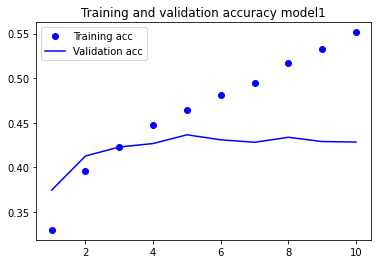

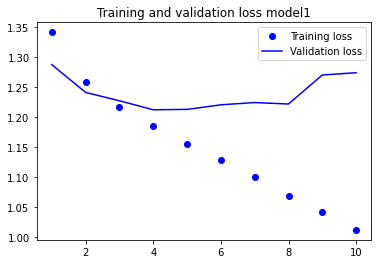

In [107]:
# Plotting the accuracy and loss of the training and validation data for the third model (cf. Chollet 2018: 192)

import matplotlib.pyplot as plt

acc_3 = history3.history['acc']
val_acc_3 = history3.history['val_acc']
loss_3 = history3.history['loss']
val_loss_3 = history3.history['val_loss']

epochs = range(1, len(acc_3) + 1)

plt.plot(epochs, acc_3, 'bo', label='Training acc')
plt.plot(epochs, val_acc_3, 'b', label='Validation acc')
plt.title('Training and validation accuracy model1')
plt.legend()

plt.figure()

plt.plot(epochs, loss_3, 'bo', label='Training loss')
plt.plot(epochs, val_loss_3, 'b', label='Validation loss')
plt.title('Training and validation loss model1')
plt.legend()

plt.show()

### Overall discussion

After training model 3 for 10 epochs we get a training loss of 1.0125, a training accuracy of 0.5515, a validation loss of 1.2740 and a validation accuracy of 0.4283. Even though this model achieves a higher accuracy than model 1 and model 2, increasing the complexity comes with severe overfitting. The plot above shows that the validation accuracy stagnates after epoch 5 and the validation loss is even increasing after epoch 8. 

The test accuracy for model 3 however is still higher than the training accuracy (0.6039 vs. 0.5515). The higher test accuracy might be explained by data leakage, i.e. an "overlap between the train and test datasets" (Elangovan et al. 2021). Although we did drop duplicates when we preprocessed the dataset, it might be possible that the dataset still contains very similar texts (e.g. might contain overlapping texts). However, the validation accuracy is always lower than the training accuracy even though we applied random shuffling before splitting the data. There might have been a mistake with shuffling and splitting the data (see 2.). In order to prevent overfitting, one should rather reduce the size of the model (cf. Chollet 2018: 104). One could also increase the dropout rate (cf. Chollet 2018: 109).

# Part 3: BERT
### 3.1 Preprocess BERT embeddings

In this section we are builing a model using BERT embeddings, more specifically the BERT base uncased model, to compare its performance with that of the models above. We followed and modified the code from https://github.com/theartificialguy/NLP-with-Deep-Learning/blob/master/BERT/Multi-Class%20classification%20TF-BERT/multi_class.ipynb.

In [22]:
#pip install -U sentence-transformers

In [60]:
from transformers import BertTokenizer
# load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 

To store the encoded input sequences and the attention masks for the encoded sequences for all rows in the dataset containing 4 labels we are initializing two numpy arrays with zeros. Both have the dimension (number of rows, maximum sequence length). 

In [62]:
input_ids = np.zeros((len(df_4), 40))
att_masks = np.zeros((len(df_4), 40))

In [63]:
def encode_text(df, ids, attention_masks, tokenizer):
    '''
    This function iterates over all rows in a dataframe. Using the encode_plus() method of the Tokenizer object, 
    it encodes the text data and stores the ids and attention masks in numpy arrays. The tqdm function is used to display a progress bar.
    '''
    for i, text in tqdm(enumerate(df['text'])):
        tokenized = tokenizer.encode_plus(
            text,
            max_length=40, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized.input_ids
        attention_masks[i, :] = tokenized.attention_mask
    return ids, attention_masks

# fill the numpy arrays inititalized with zeros with the input ids and attention masks for the dataset
input_ids, att_masks = encode_text(df_4, input_ids, att_masks, tokenizer)

35756it [00:20, 1707.59it/s]


In [64]:
# initializing a NumPy array with zeros for the labels
labels = np.zeros((len(df_4), 4))
labels.shape

from keras.utils import to_categorical
# use one-hot encoding to convert labels
labels = to_categorical(np.asarray(df_4['character_name_cat'])) 

Here we are creating a TensorFlow dataset from the input_ids, att_masks, and labels so the data can be properly fed into the model. 

In [65]:
import tensorflow as tf
# create a data pipeline for feeding the encoded input sequences, attention masks and label data into the model
dataset = tf.data.Dataset.from_tensor_slices((input_ids, att_masks, labels))
dataset.take(1) # retrieve first sample in data set and check its shape and content 

<TakeDataset element_spec=(TensorSpec(shape=(40,), dtype=tf.float64, name=None), TensorSpec(shape=(40,), dtype=tf.float64, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>

In [66]:
# creating dictionaries
def SentimentDatasetMapFunction(input_ids, att_masks, labels):
    '''This function maps the encoded input sequences, attention masks and labels to a format required by the input layer of the BERT model.
    It returns a dictionary with two keys (input_ids and attention_mask) that can be later used as input to the map method of a tf.data.Dataset object.'''
    return {
        'input_ids': input_ids,
        'attention_mask': att_masks
    }, labels

In [67]:
# transform data according to the SentimentDataSetMapfunction (required format for tensorflow dataset)
converting to required format for tensorflow dataset
dataset = dataset.map(SentimentDatasetMapFunction) 
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(40,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(40,), dtype=tf.float64, name=None)}, TensorSpec(shape=(4,), dtype=tf.float32, name=None))>

In [68]:
# random shuffling of the data and setting the batch size to 16
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True)

In [69]:
# split the dataset into train, val, and test sets

p_train = 0.8
p_val = 0.1
p_test = 0.1

num_samples = len(df_4)//16
train_size = int(num_samples * p_train)
val_size = int(num_samples * p_val)

train_dataset = dataset.take(train_size)
remaining_dataset = dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(val_size)

In [70]:
# loading the bert-uncased model
from transformers import TFBertModel
model = TFBertModel.from_pretrained('bert-base-uncased')


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


The following code snippet defines a new Keras model that takes the takes the BERT embeddings as input (or to be more specific the input_ids and attention_mask tensors) and contains two additional Dense layers with 512 and 4 units respectively. The bert_embds contains an extracted pooled output tensor which can be further processed by the following layers in the network. The intermediate layer uses the relu activation function which is commonly used in intermediate layers. The output layer uses the softmax activation function which is suitable for our multiclass classidication task. We have four output units corresponding to the four character labels and the output of the model is a probablity distribution over these four classes.

In [72]:
# freeze weights of BERT's layers (prevent weights from pre-trained BERT model from updating)
bert = model.bert 

for layer in bert.submodules:
    layer.trainable = False


# defining the two input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(40,), name='input_ids', dtype='int32')
att_masks = tf.keras.layers.Input(shape=(40,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=att_masks)[1] # getting the pooled output layer

intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(4, activation='softmax', name='output_layer')(intermediate_layer)

bert_model = tf.keras.Model(inputs=[input_ids, att_masks], outputs=output_layer)
bert_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 40)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 40,                                          

We define the optimizer as Adam, the loss function as CategoricalCrossentropy (because we are dealing with a multiclass classification problem) and the metric as accuracy.

In [73]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')


In [74]:
bert_model.compile(optimizer=optim, loss=loss_func, metrics=['acc'])

In [75]:
# train model 
history = bert_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10
1787/1787 [==============================] - 74s 38ms/step - loss: 1.3896 - acc: 0.2660 - val_loss: 1.3761 - val_acc: 0.2999
Epoch 2/10
1787/1787 [==============================] - 65s 36ms/step - loss: 1.3768 - acc: 0.2876 - val_loss: 1.3802 - val_acc: 0.2772
Epoch 3/10
1787/1787 [==============================] - 66s 37ms/step - loss: 1.3692 - acc: 0.3075 - val_loss: 1.3690 - val_acc: 0.2909
Epoch 4/10
1787/1787 [==============================] - 66s 36ms/step - loss: 1.3636 - acc: 0.3176 - val_loss: 1.3558 - val_acc: 0.3271
Epoch 5/10
1787/1787 [==============================] - 64s 36ms/step - loss: 1.3593 - acc: 0.3251 - val_loss: 1.3545 - val_acc: 0.3237
Epoch 6/10
1787/1787 [==============================] - 64s 36ms/step - loss: 1.3561 - acc: 0.3267 - val_loss: 1.3539 - val_acc: 0.3226
Epoch 7/10
1787/1787 [==============================] - 67s 38ms/step - loss: 1.3533 - acc: 0.3336 - val_loss: 1.3459 - val_acc: 0.3459
Epoch 8/10
1787/1787 [==========================

In [76]:
# evaluate model on test data
test_loss, test_acc = bert_model.evaluate(test_dataset, verbose=0)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 1.3338123559951782
Test accuracy: 0.3565848171710968


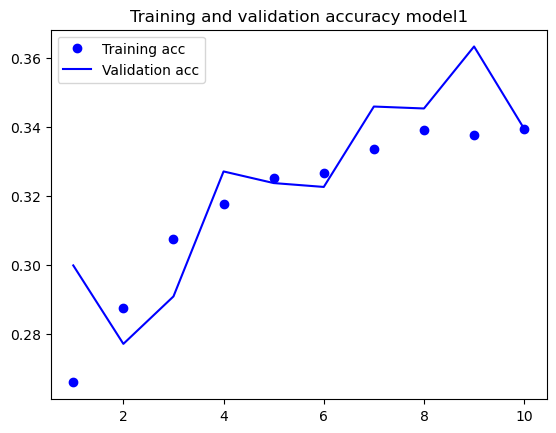

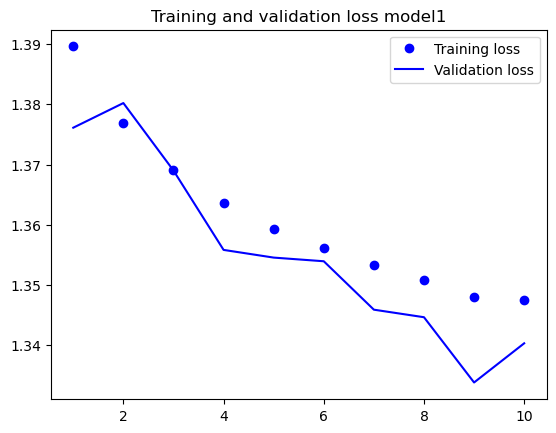

In [77]:
# plotting the accuracy and loss of the training and validation data for the BERT model (cf. Chollet 2018: 192)

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy model')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss model')
plt.legend()

plt.show()

### Conclusion

The overall performance of the model using BERT embeddings is very poor. After training the model for 10 epochs we only reach an accuracy of 0.3394 and the validation accuracy (and loss) fluctuate heavily. Contrary to our prediction, the accuracy of the BERT model is lower than that of all models using GloVe embeddings for the dataset containing 4 labels (0.4772 for model 2 and 0.5515 for model 3). One explanation for this might be that the model architecture is too simplistic since it only contains one intermediate Dense layer with 512 units. One could increase the complexity of the model and apply more finetuning of hyperparameters. Moreover, the text classification problem at hand might be too simple for a complex model involving BERT embeddings, which are even more complex than the static GloVe embeddings. As Chollet (2018: 206) points out for sentiment analysis (also a text classification task), "such a basic problem is well solved by looking at what words occur in each review, and at what frequency". Moreover, as Dharma et al. (2022) state, the accuracy of GloVe and BERT might depend highly on the dataset used for the text classification task.

### References

Chollet, F. (2018). Deep learning with Python. Shelter Island Manning.

Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2018). Bert: Pre-training of deep bidirectional transformers for language understanding. arXiv preprint arXiv:1810.04805.

Dharma, E. M., Gaol, F. L., Warnars, H. L. H. S., & Soewito, B. E. N. F. A. N. O. (2022). The accuracy comparison among Word2vec, Glove, and Fasttext towards convolution neural network (CNN) text classification. Journal of Theoretical and Applied Information Technology, 100(2), 31.

Elangovan, A., He, J., & Verspoor, K. (2021). Memorization vs. generalization: quantifying data leakage in NLP performance evaluation. arXiv preprint arXiv:2102.01818.

Frassinelli, D. (2002). Deep Learning with Python. Lecture Slides.

Kingma, D. P., & Ba, J. (2014). Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980.

Liu, X. Y., Wu, J., & Zhou, Z. H. (2008). Exploratory undersampling for class-imbalance learning. IEEE Transactions on Systems, Man, and Cybernetics, Part B (Cybernetics), 39(2), 539-550.

Pascanu, R., Mikolov, T., & Bengio, Y. (2013). On the difficulty of training recurrent neural networks. In International conference on machine learning (pp. 1310-1318). Pmlr.